Data Preprocessing

In [4]:
import torch

if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    print(f"Number of GPUs available: {n_gpu}")
    for i in range(n_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU is available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4090


In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
#import matplotlib.patches as patches

def parse_annotation(annotation_line):
    parts = annotation_line.strip().split()
    class_id = int(parts[0])  # The class_id is the first element
    vertices = np.array(parts[1:], dtype=np.float32)  # The rest are the vertices
    return class_id, vertices.reshape((-1, 2))  # Reshape to Nx2 where N is the number of vertices

def draw_polygon_on_mask(mask, corners, image_shape):
    scaled_corners = corners * np.array([image_shape[1], image_shape[0]], dtype=np.float32)  # scale x and y
    scaled_corners = np.around(scaled_corners).astype(np.int32)  # round and convert to int

    # print("Scaled Corners:", scaled_corners)  # Debugging print

    corners_int = scaled_corners.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [corners_int], color=(255))  # Ensure fillPoly is used, not polylines

    # # Debugging visualization
    # plt.imshow(mask, cmap='gray')
    # plt.title('Polygon on Mask')
    # plt.axis('off')
    # plt.show()

def create_mask_from_annotations(annotation_path, image_shape):
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)  # Create a black mask
    with open(annotation_path, 'r') as file:
        for line in file:
            class_id, vertices = parse_annotation(line)
            draw_polygon_on_mask(mask, vertices, image_shape)  # Draw each polygon on the mask
    return mask

def preprocess_image(image_path, annotation_path, target_size):
    # Open and resize image
    image = Image.open(image_path).resize(target_size)
    mask = create_mask_from_annotations(annotation_path, target_size)  # Note the reversal of width and height for the mask
    return np.array(image), mask

# def debug_visualization(image, mask, corners, title='Debug Visualization'):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     
#     # Show original image with annotations
#     ax[0].imshow(image)
#     ax[0].set_title(f'{title}: Original Image with Annotations')
#     for corner in corners:
#         scaled_corners = corner * np.array([image.shape[1], image.shape[0]])
#         polygon = patches.Polygon(scaled_corners, linewidth=1, edgecolor='r', facecolor='none')
#         ax[0].add_patch(polygon)
# 
#     # Show mask
#     ax[1].imshow(mask, cmap='gray')
#     ax[1].set_title(f'{title}: Mask')
# 
#     plt.tight_layout()
#     plt.show()

def process_directory(data_dir, annotation_dir, target_size):
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            # Paths for the image and its corresponding annotation file
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))

            # Check if the annotation file exists
            if not os.path.isfile(annotation_path):
                print(f"Annotation file does not exist for {image_path}")
                continue  # Skip this image

            # Preprocess the image and create the mask from the annotation
            image, mask = preprocess_image(image_path, annotation_path, target_size)

            # Visualization for debugging
            corners = []  # Store the vertices for debugging visualization
            with open(annotation_path, 'r') as file:
                for line in file:
                    class_id, vertices = parse_annotation(line)
                    corners.append(vertices)

            #debug_visualization(image, mask, corners, title=os.path.basename(image_path))

            # Save the processed image and mask as .npy files
            image_npy_path = os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy'))
            mask_npy_path = os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy'))

            np.save(image_npy_path, image)
            np.save(mask_npy_path, mask)

def save_as_npy(data_dir, annotation_dir, target_size=(224, 224)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            processed_data.append((image, mask))
    print(f"Processed and saved {len(processed_data)} image-mask pairs in .npy format.")

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title('Processed Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Processed Mask')
# plt.axis('off')
# 
# plt.show()
# Example usage
dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (224, 224)  # Change as required by your model

# Process images and annotations and save them as .npy files
# Process images and annotations
for part in partitions:
    images_dir = os.path.join(dataset_base, part, 'images')
    annotations_dir = os.path.join(dataset_base, part, 'labels')
    process_directory(images_dir, annotations_dir, target_size)
    print(f"Finished processing {part} set")

# Visualization (example for one image from the 'train' set)
train_images_dir = os.path.join(dataset_base, 'train', 'images')
train_image_files = [f for f in os.listdir(train_images_dir) if f.endswith('_img.npy')]

# Load one image and its corresponding mask
image = np.load(os.path.join(train_images_dir, train_image_files[0]))
mask = np.load(os.path.join(train_images_dir, train_image_files[0].replace('_img.npy', '_mask.npy')))

# # Visualize the image and the mask
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title('Processed Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Processed Mask')
# plt.axis('off')
# 
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb/train/images'


Semantics CNN

Found 8691 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\train\images
Found 2483 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\valid\images
Found 1242 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\test\images
Epoch 1, Validation Loss: 0.6277, Validation Accuracy: 0.4415, Precision: 0.2927, Recall: 0.9276, F1 Score: 0.4450
Test Loss: 0.6272, Test Accuracy: 0.4411, Precision: 0.2925, Recall: 0.9270, F1 Score: 0.4447


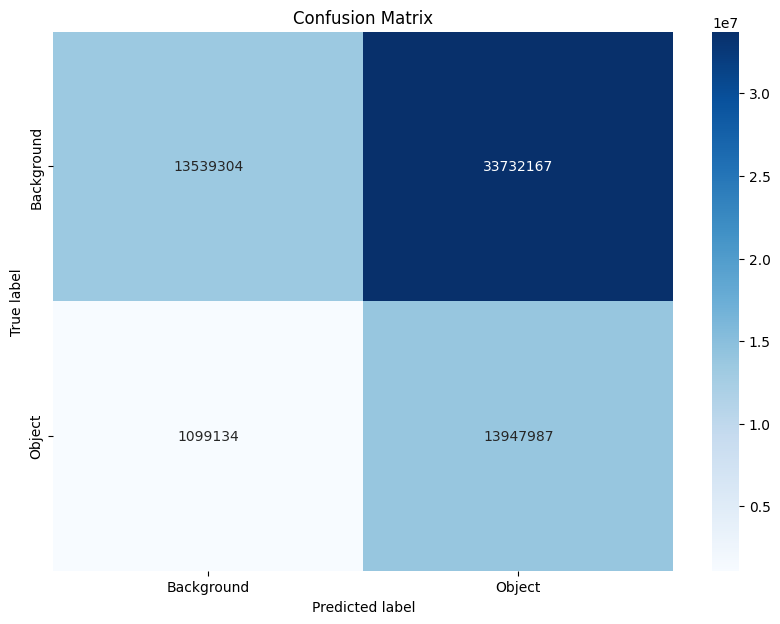

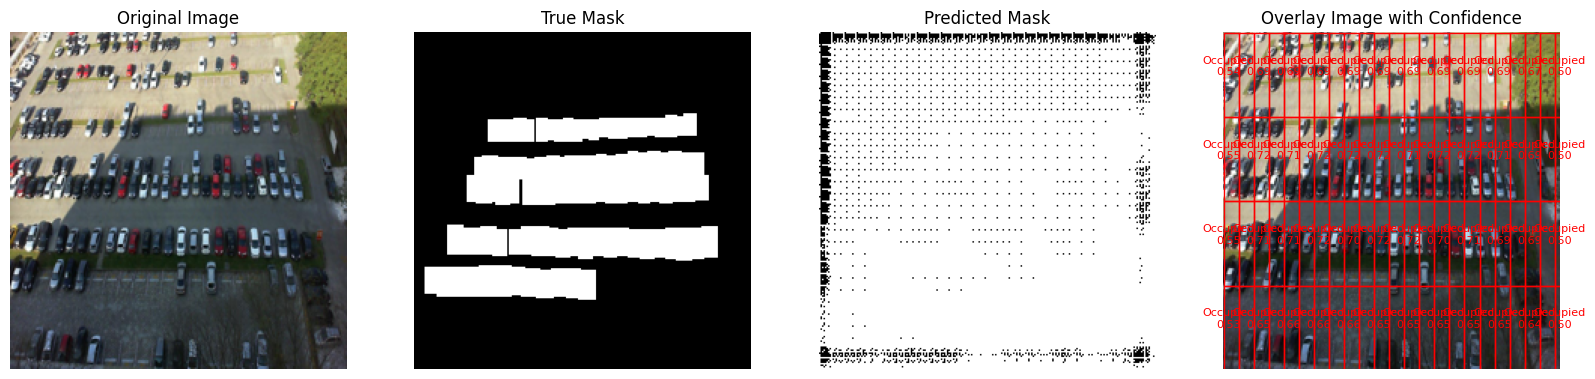

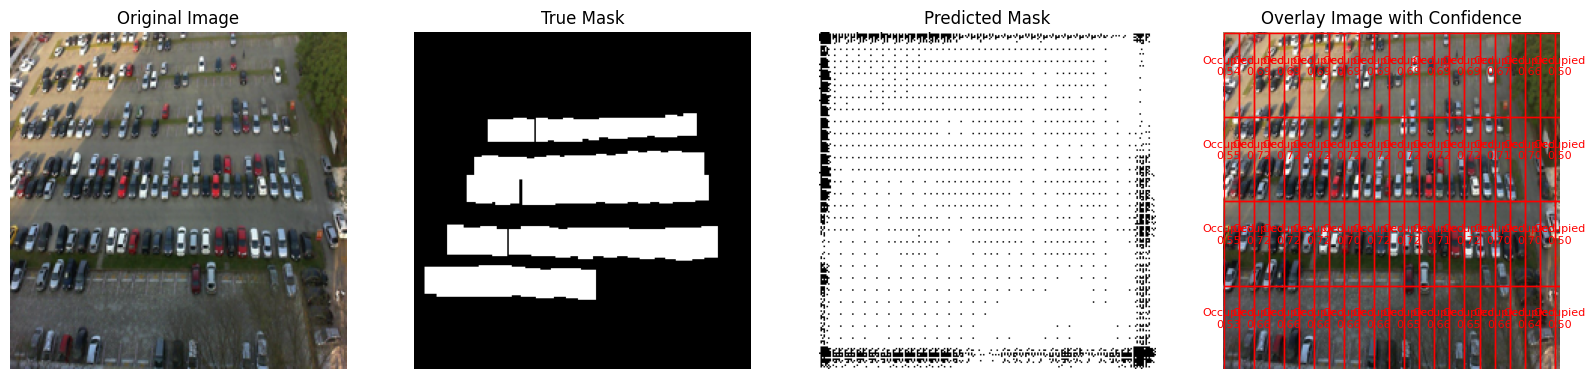

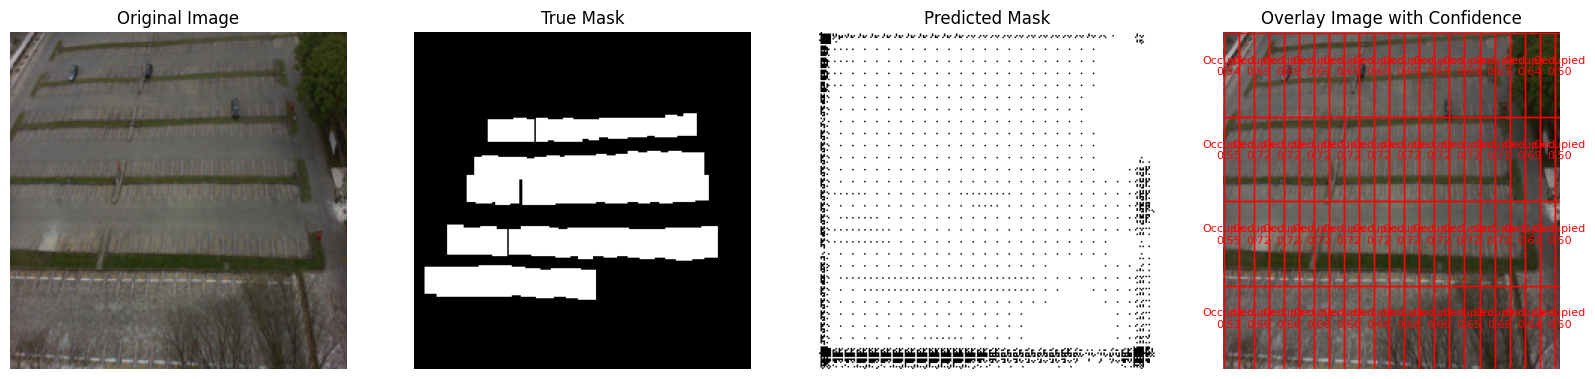

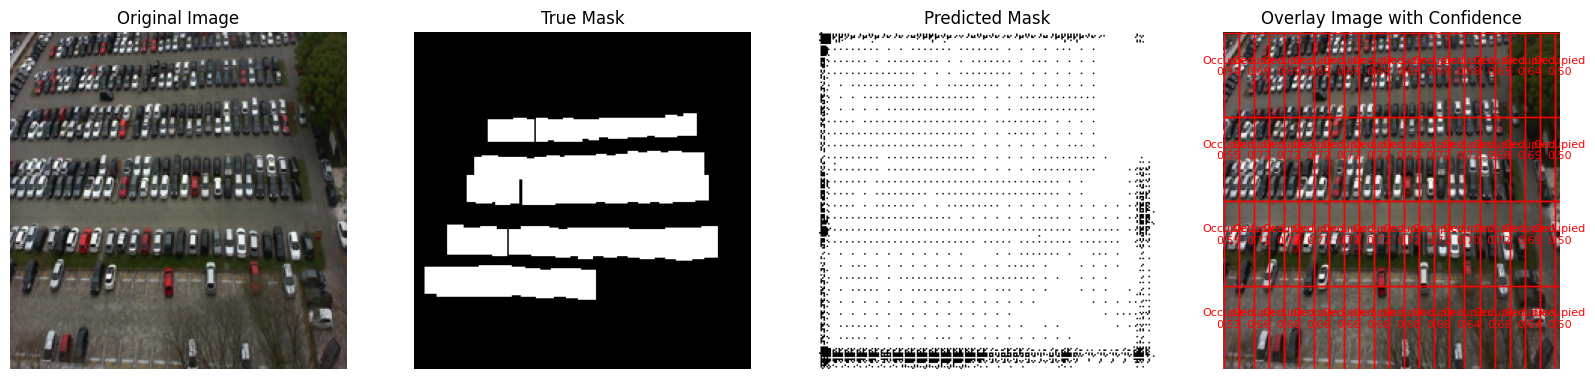

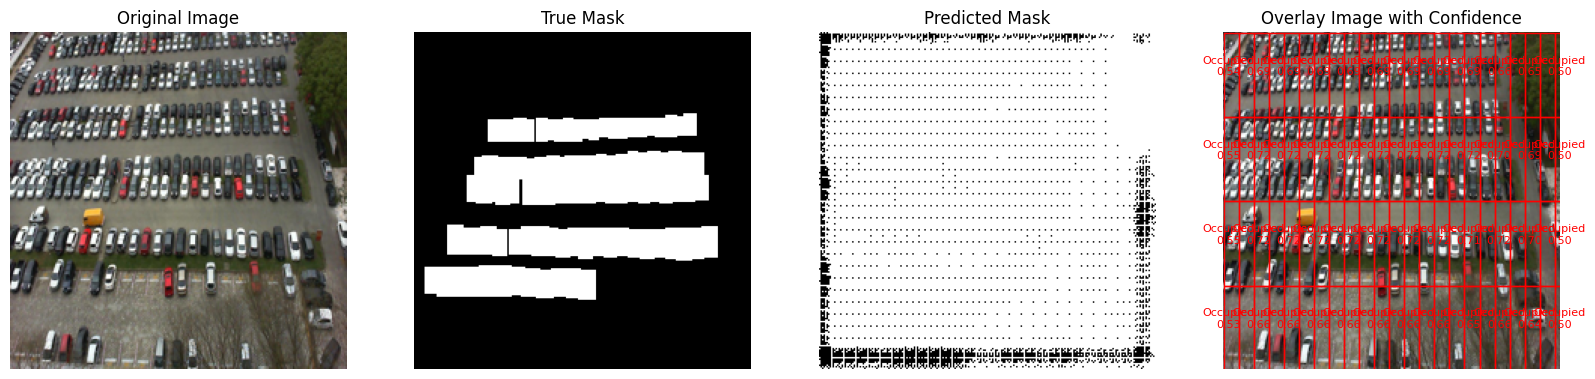

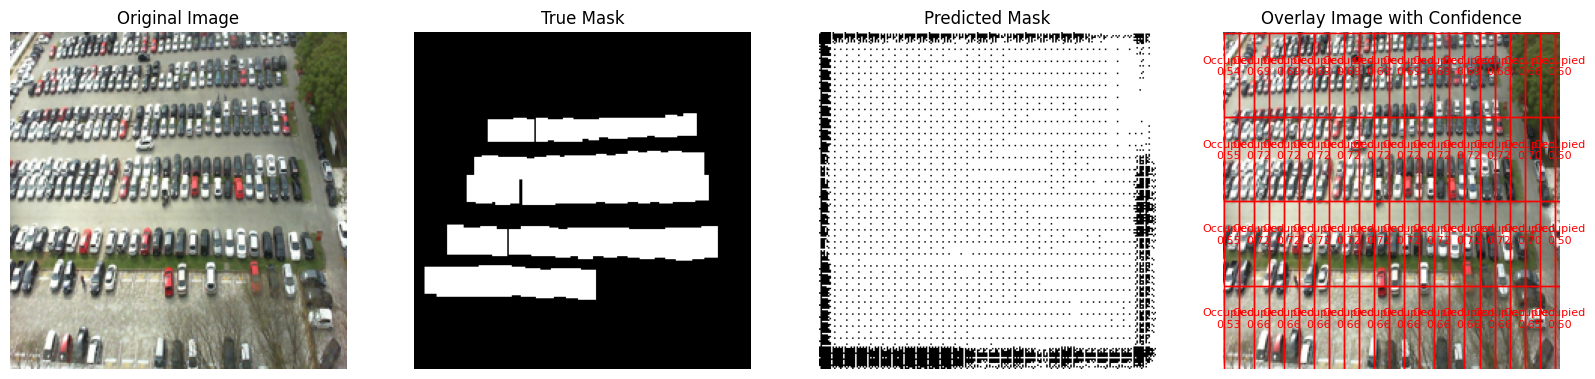

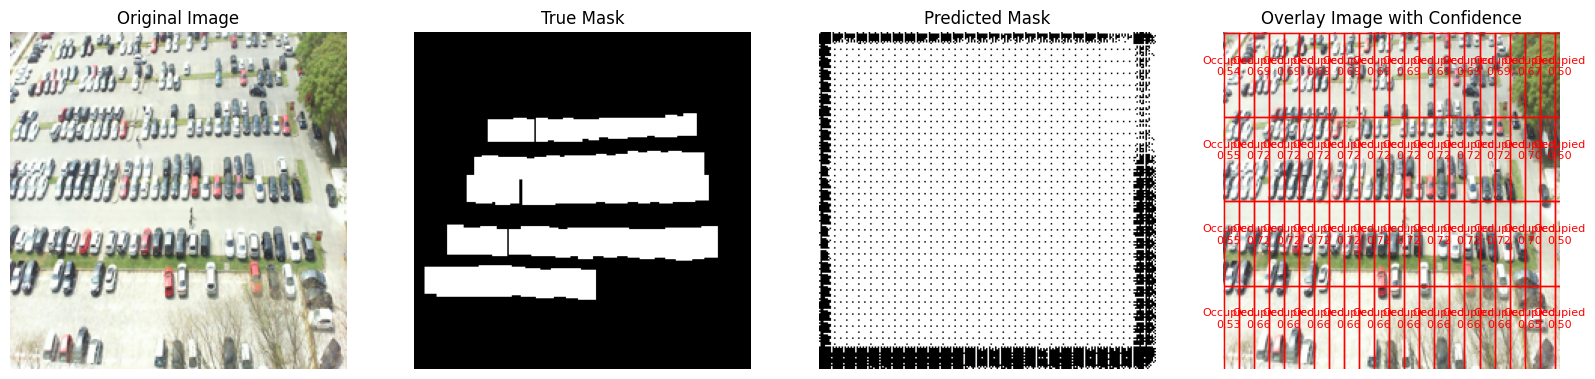

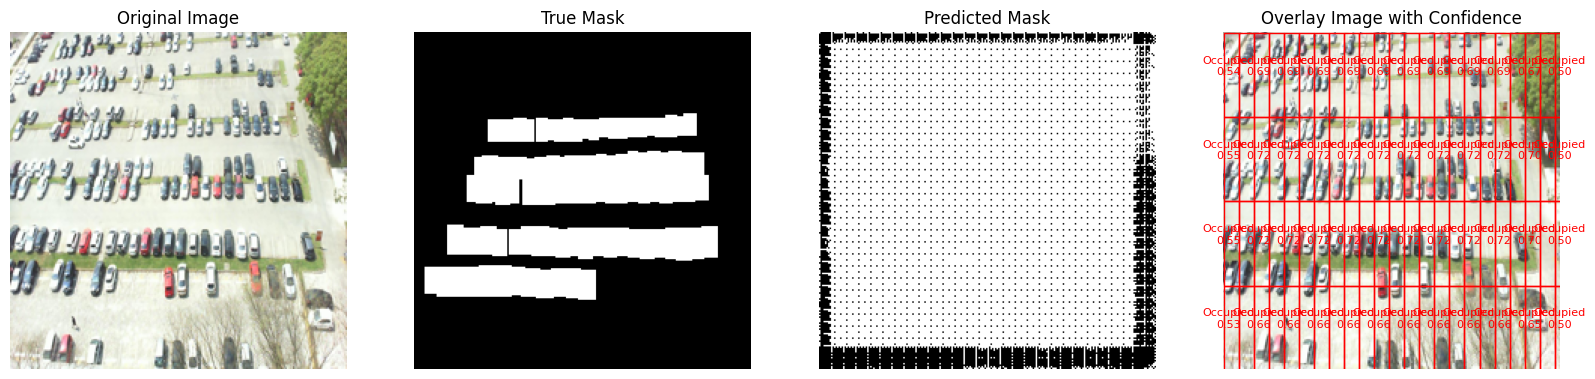

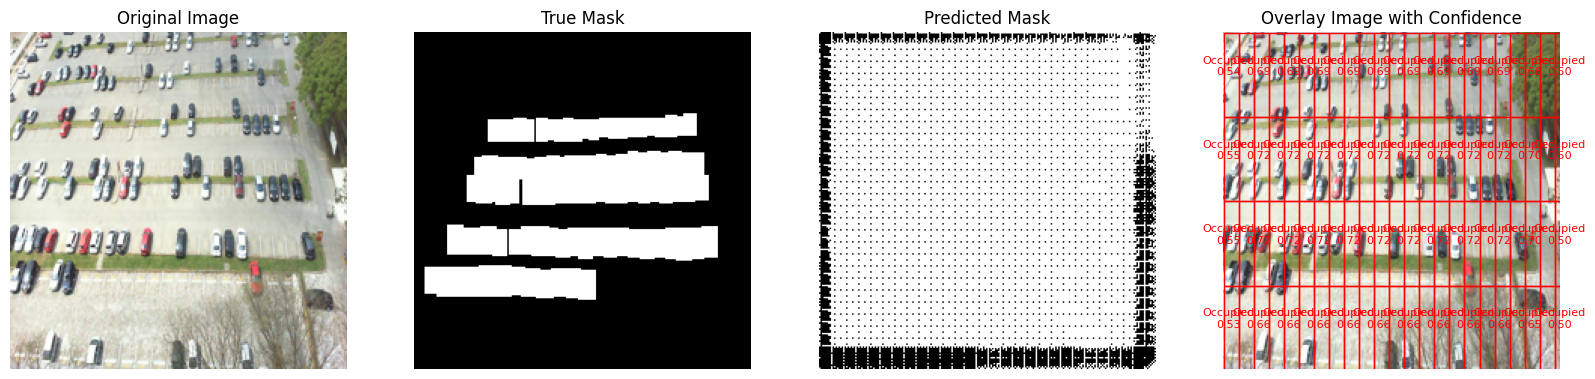

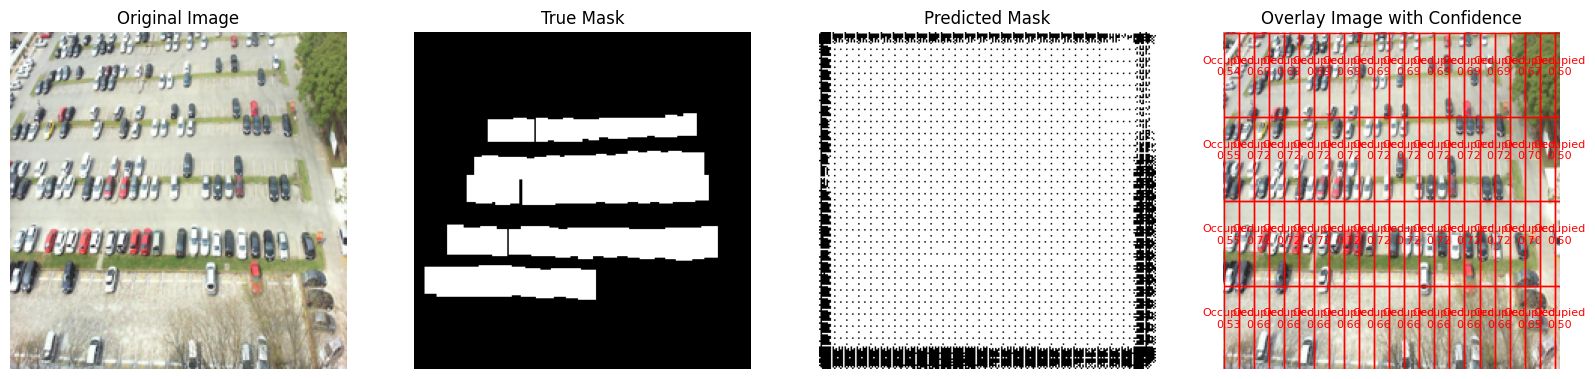

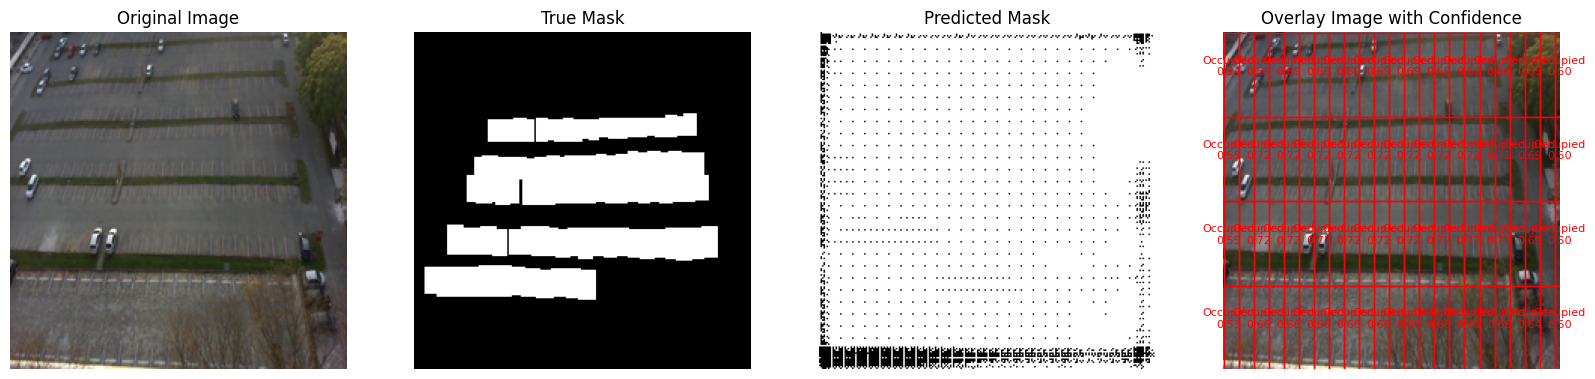

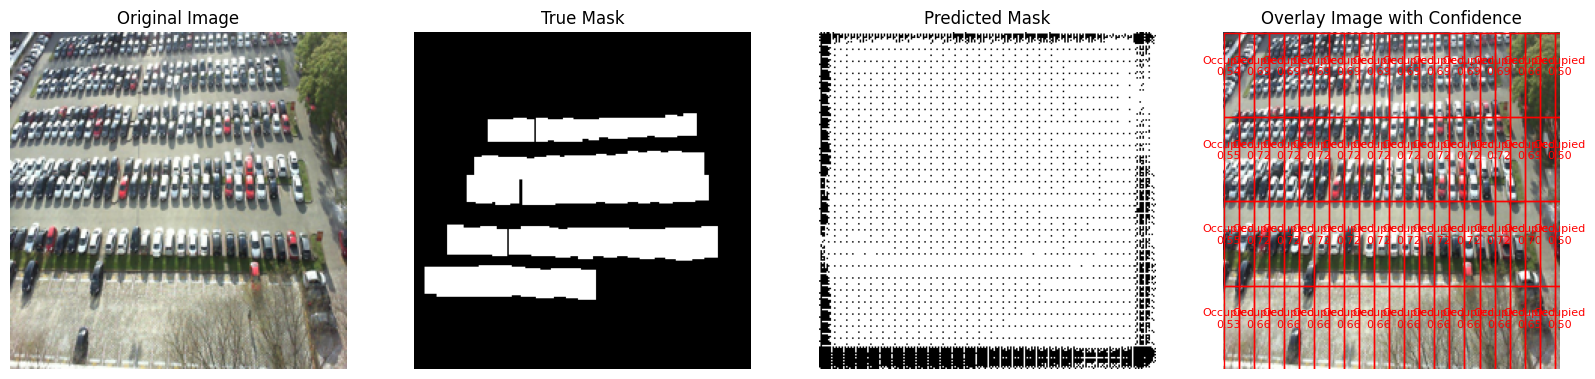

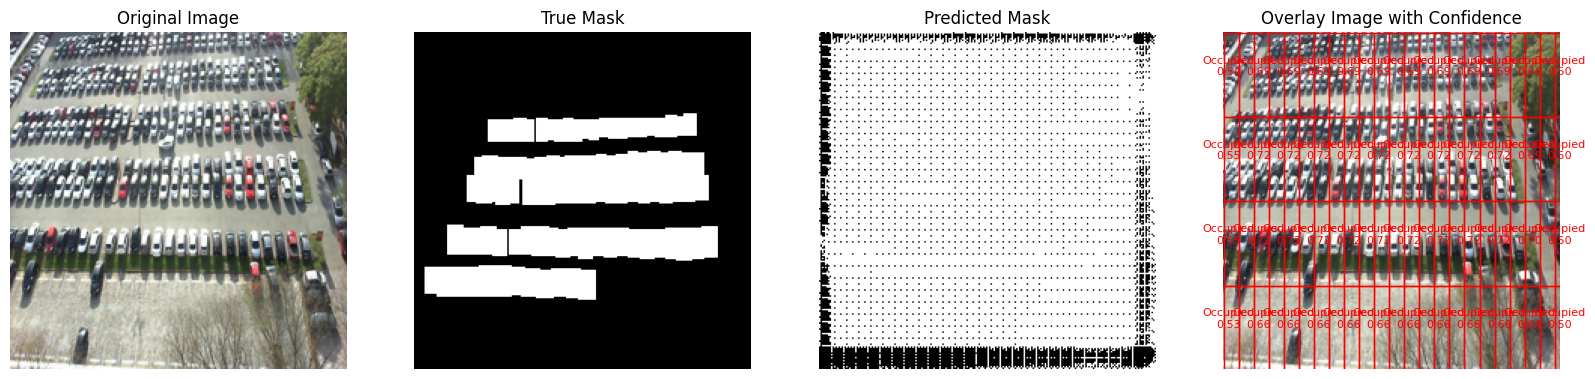

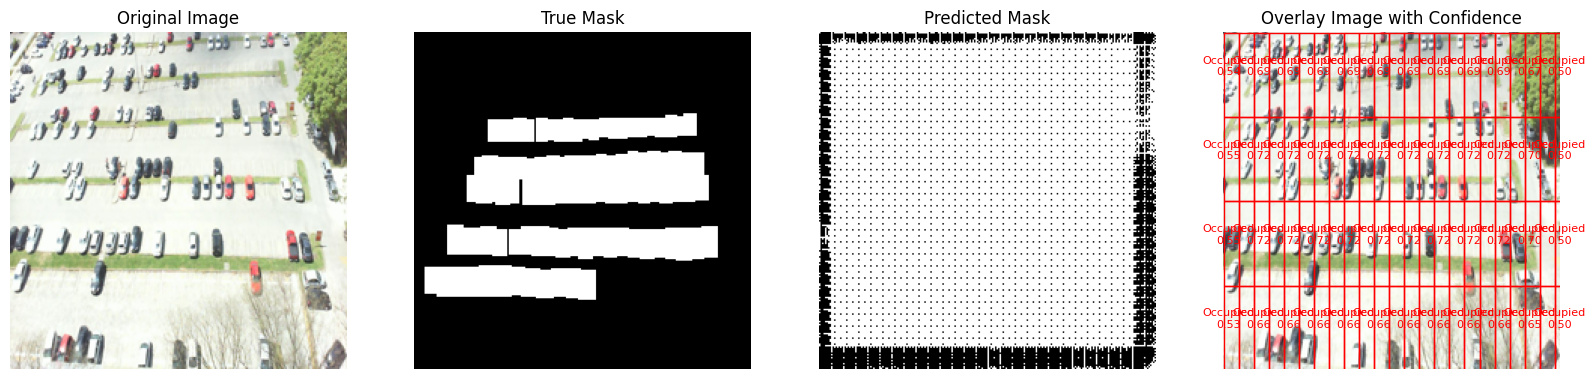

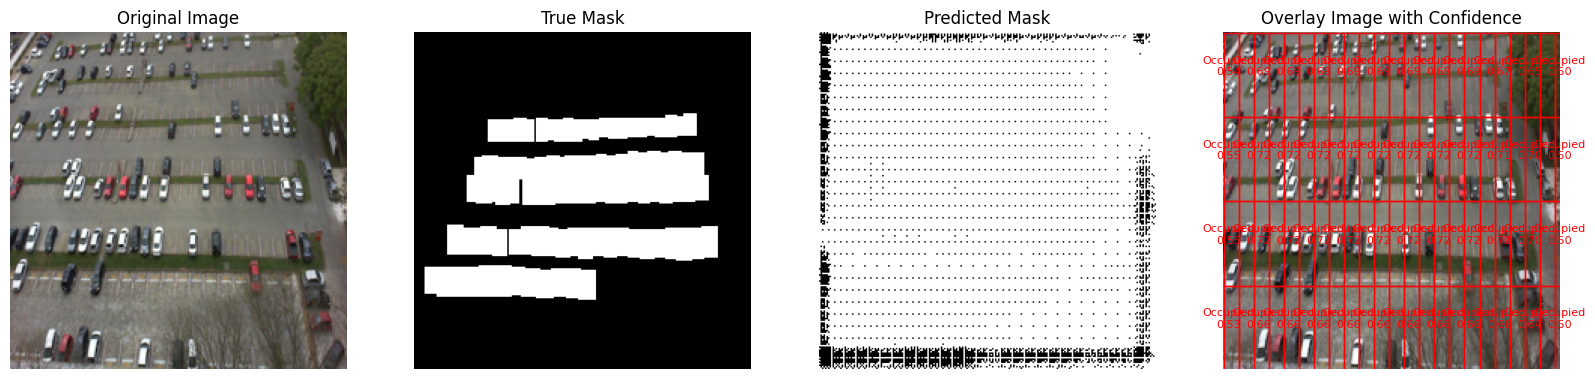

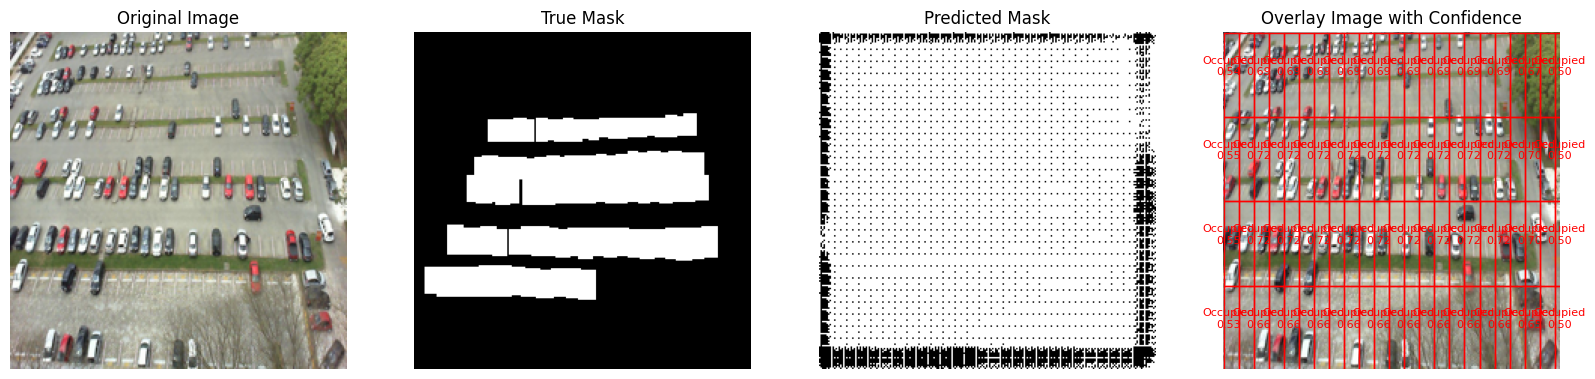

Total Time taken for inference: 243.6922 seconds


In [7]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time

# Define the CNN architecture for segmentation
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (256, 256)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel().to(device)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (outputs > 0.5).float()
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()
            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)
    return average_loss, accuracy, precision, recall, f1, cm

# Training loop
for epoch in range(1):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation data
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

def plot_confusion_matrix(cm, classes=['Background', 'Object'], title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

plot_confusion_matrix(test_cm)
# Save the trained model
torch.save(model, 'CNN_model.pth')

# Load the trained model for testing
loaded_model = torch.load('CNN_model.pth')
loaded_model.eval()
 
# Visualize the model predictions with confidence scores
def visualize_with_confidence(model, loader, device, num_examples=1, threshold=0.5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_examples:  # Only visualize a certain number of examples
                break

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > threshold).float()

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            sigmoid_outputs_np = sigmoid_outputs.cpu().numpy()

            for idx in range(len(images)):
                fig, ax = plt.subplots(1, 4, figsize=(20, 5))

                ax[0].imshow(images_np[idx].transpose(1, 2, 0))
                ax[0].set_title('Original Image')
                ax[0].axis('off')

                ax[1].imshow(masks_np[idx].squeeze(), cmap='gray')
                ax[1].set_title('True Mask')
                ax[1].axis('off')

                ax[2].imshow(preds_np[idx].squeeze(), cmap='gray')
                ax[2].set_title('Predicted Mask')
                ax[2].axis('off')

                overlay_image = images_np[idx].transpose(1, 2, 0).copy()
                step_size_height = overlay_image.shape[0] // 4  # where `number_of_rows` is the number of parking rows in the image
                step_size_width = overlay_image.shape[1] // 22  # where `number_of_slots_per_row` is the number of parking slots per row in the image

                for y in range(0, preds_np[idx].shape[1], step_size_height):  
                    for x in range(0, preds_np[idx].shape[2], step_size_width):  
                        conf_score = np.mean(sigmoid_outputs_np[idx][:, y:y+step_size_height, x:x+step_size_width])
                        status = "Occupied" if conf_score > threshold else "Empty"
                        color = 'r' if status == "Occupied" else 'g'
                        rect = patches.Rectangle((x, y), step_size_width, step_size_height, linewidth=1, edgecolor=color, facecolor='none')
                        ax[3].add_patch(rect)
                        # To prevent text overlay, consider only labeling every other slot or a selection of slots
                        if (x // step_size_width) % 2 == 0:  # Example condition to reduce label frequency
                            ax[3].text(x+3, y+step_size_height//2, f'{status}\n{conf_score:.2f}', color=color, fontsize=8, ha='center')
                ax[3].imshow(overlay_image)
                ax[3].set_title('Overlay Image with Confidence')
                ax[3].axis('off')
                plt.show()

# Call the function with train or test loader
visualize_with_confidence(model, test_loader, device, num_examples=1, threshold=0.5)

end_time = time.time()
inference_time = end_time - start_time
print(f"Total Time taken for inference: {inference_time:.4f} seconds")

In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import timm
from PIL import Image, ImageDraw
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
from torch.profiler import profile, record_function, ProfilerActivity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class VisionTransformerForSegmentation(nn.Module):
    def __init__(self, img_size, num_classes):
        super(VisionTransformerForSegmentation, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # No classification head
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        self.img_size = img_size

    def forward(self, x):
        # Extract features from the transformer
        x = self.vit(x)  # Output shape: [batch_size, 768]
        # Reshape to add spatial dimensions: Assume a starting size of 1x1
        x = x.view(x.size(0), 768, 1, 1)  # Now: [batch_size, 768, 1, 1]
        # Upsample to a larger spatial size
        x = F.interpolate(x, size=(12, 12), mode='bilinear', align_corners=False)  # Increase spatial dimensions
        # Decode to the final image size and number of classes
        x = self.decoder(x)
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        return x
class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)

        if self.transform:
            image = self.transform(image)  # Make sure the transformation is applied here

        return image, mask
    
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        # Assuming the foreground class is at channel index 1
        outputs = outputs[:, 1, :, :]  # Select only the foreground class probabilities
        targets = targets.float()  # Ensure targets are float for multiplication

        intersection = (outputs * targets).sum(dim=(1, 2))  # Sum over spatial dimensions
        total = (outputs + targets).sum(dim=(1, 2))
        dice = (2. * intersection + self.smooth) / (total + self.smooth)
        return 1 - dice.mean()  # Average over the batch

# Define the evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Convert outputs to binary predictions for the class of interest
            preds = torch.sigmoid(outputs)[:, 1, :, :] > 0.5
            preds = preds.float()  # Ensure same data type as masks if needed

            loss.backward()
            optimizer.step()

            # Update metrics
            total_loss += loss.item() * images.size(0)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()

            average_loss = total_loss / len(loader.dataset)
            accuracy = total_correct / total_pixels
        return average_loss, accuracy

dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (512, 512)

# Create datasets and dataloaders for train, validation, and test sets
image_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert arrays to PIL Images if not already
    transforms.Resize((224, 224)),  # Resize the image to the expected dimensions
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformations for the masks
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the mask
    transforms.ToTensor()  # Convert mask to tensor without normalization
])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=image_transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=image_transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

# Initialize device and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformerForSegmentation(img_size=224, num_classes=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = DiceLoss()

start_time = time.time()
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
def train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=1):
    model.train()
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_pixels = 0
        total_correct = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            with torch.no_grad():
                preds = torch.sigmoid(outputs)[:, 1, :, :] > 0.5
                total_correct += (preds == masks).sum().item()
                total_pixels += masks.numel()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / total_pixels
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

        # Validation step
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                valid_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs)[:, 1, :, :] > 0.5
                valid_correct += (preds == masks).float().sum().item()
                valid_total += masks.numel()

        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = valid_correct / valid_total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        print(f'Validation - Epoch {epoch+1}: Validation Loss = {valid_loss:.4f}, Validation Accuracy = {valid_accuracy:.4f}')

train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=1)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=1)
print(prof.key_averages().table(sort_by="cuda_time_total")) 
# Plotting training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training vs validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'car_segmentation_model1.pth')

# Load the trained model for testing
model.load_state_dict(torch.load('car_segmentation_model1.pth'))
model.to(device)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            total_loss += loss.item() * images.size(0)
            total_correct += (preds == masks).float().sum().item()
            total_pixels += masks.numel()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)

    return average_loss, accuracy, precision, recall, f1, cm

# Calculate test metrics and plot confusion matrix
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(test_cm, classes=['Background', 'Object'], title='Test Confusion Matrix')

def visualize_slot_status(model, loader, device, criterion, threshold=0.5, num_images=5):
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()
            
            # Process each image in the batch
            for i in range(images.size(0)):
                # Convert tensor to PIL Image for easy manipulation
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
                original_img = Image.fromarray(img_np)
                draw = ImageDraw.Draw(original_img)

                # Convert predictions to numpy for processing
                pred_np = preds[i].cpu().numpy().squeeze()

                # Define the slot size and overlay settings
                slot_height, slot_width = 32, 32  # Adjust based on your dataset specifics

                for y in range(0, pred_np.shape[0], slot_height):
                    for x in range(0, pred_np.shape[1], slot_width):
                        value = pred_np[y:y+slot_height, x:x+slot_width].mean()
                        if value > threshold:
                            draw.rectangle([x, y, x + slot_width, y + slot_height], outline="red", fill=(255, 0, 0, 125))
                            draw.text((x + 5, y + 5), "Occupied", fill="white")
                        else:
                            draw.rectangle([x, y, x + slot_width, y + slot_height], outline="purple", fill=(128, 0, 128, 125))
                            draw.text((x + 5, y + 5), "Empty", fill="white")

                # Display the annotated image
                plt.figure(figsize=(10, 10))
                plt.imshow(original_img)
                plt.axis('off')
                plt.show()

# Example usage
visualize_slot_status(model, test_loader, device, DiceLoss(), threshold=0.5, num_images=5)  

end_time = time.time()
inference_time = end_time - start_time
print(f"Total Time taken for inference: {inference_time:.4f} seconds")

In [78]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import timm
from PIL import Image, ImageDraw
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
from transformers import ViTFeatureExtractor, ViTForImageClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def get_pretrained_vit(num_classes):
    # Initialize the feature extractor and model from the Hugging Face Transformers library
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384')
    pretrained_vit = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')

    # Freeze all the parameters in the pre-trained model
    for param in pretrained_vit.parameters():
        param.requires_grad = False

    # Replace the classifier head with a new one appropriate for your number of classes
    # Adjust the in_features to match the output features of the ViT model which is usually 768 for BERT base models
    pretrained_vit.classifier = nn.Sequential(
        nn.Linear(768, num_classes))  # 768 is typical for ViT-Large models

    # Make sure the new classifier has requires_grad enabled
    for param in pretrained_vit.classifier.parameters():
        param.requires_grad = True

    # Define loss function and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pretrained_vit.classifier.parameters(), lr=0.0003)  # Only optimize the new classifier

    return pretrained_vit, loss_func, optimizer

# Define the evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = outputs > 0.5
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return average_loss, accuracy

dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (224, 224)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        intersection = (outputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (outputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# Create datasets and dataloaders for train, validation, and test sets
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for the masks
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the mask
    transforms.ToTensor()  # Convert mask to tensor without normalization
])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), image_transform=image_transform, mask_transform=mask_transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), image_transform=image_transform, mask_transform=mask_transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize device and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformerForSegmentation(img_size=224, num_classes=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = DiceLoss()

def calculate_accuracy(outputs, masks, threshold=0.5):
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(outputs)
    # Apply threshold to get binary tensor
    preds = (probs > threshold).float()
    # Calculate accuracy
    correct = (preds == masks).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

# Initialize lists to store accuracies for each batch
accuracies = []
train_losses = []
valid_losses = []
valid_accuracies = []
train_accuracies = []
start_time = time.time()
# Training loop
train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Training loop with metrics
for epoch in range(1):
    model.train()
    total_loss, total_correct, total_pixels = 0, 0, 0
    all_preds, all_trues = [], []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        total_loss += loss.item() * images.size(0)
        total_correct += preds.eq(masks).sum().item()
        total_pixels += masks.numel()

        all_preds.append(preds.contiguous().view(-1).cpu().numpy())
        all_trues.append(masks.contiguous().view(-1).cpu().numpy())

    # Calculate metrics for the epoch
    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_acc = total_correct / total_pixels
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    precision, recall, f1, _ = precision_recall_fscore_support(all_trues, all_preds, average='binary')

    train_metrics['loss'].append(epoch_loss)
    train_metrics['accuracy'].append(epoch_acc)
    train_metrics['precision'].append(precision)
    train_metrics['recall'].append(recall)
    train_metrics['f1'].append(f1)

    print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    
    # Validation step
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            valid_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            valid_correct += (preds == masks).float().sum().item()
            valid_total += masks.numel()
    
    valid_losses.append(valid_loss / len(valid_loader.dataset))
    valid_accuracies.append(valid_correct / valid_total)

    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {valid_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}')

# Plotting training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training vs validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'car_segmentation_model1.pth')

# Load the trained model for testing
model.load_state_dict(torch.load('car_segmentation_model1.pth'))
model.to(device)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            total_loss += loss.item() * images.size(0)
            total_correct += (preds == masks).float().sum().item()
            total_pixels += masks.numel()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)

    return average_loss, accuracy, precision, recall, f1, cm

# Calculate test metrics and plot confusion matrix
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(test_cm, classes=['Background', 'Object'], title='Test Confusion Matrix')

def visualize_slot_status(model, loader, device, criterion, threshold=0.5, num_images=5):
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()
            
            # Process each image in the batch
            for i in range(images.size(0)):
                # Convert tensor to PIL Image for easy manipulation
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
                original_img = Image.fromarray(img_np)
                draw = ImageDraw.Draw(original_img)

                # Convert predictions to numpy for processing
                pred_np = preds[i].cpu().numpy().squeeze()

                # Define the slot size and overlay settings
                slot_height, slot_width = 32, 32  # Adjust based on your dataset specifics

                for y in range(0, pred_np.shape[0], slot_height):
                    for x in range(0, pred_np.shape[1], slot_width):
                        value = pred_np[y:y+slot_height, x:x+slot_width].mean()
                        if value > threshold:
                            draw.rectangle([x, y, x + slot_width, y + slot_height], outline="red", fill=(255, 0, 0, 125))
                            draw.text((x + 5, y + 5), "Occupied", fill="white")
                        else:
                            draw.rectangle([x, y, x + slot_width, y + slot_height], outline="purple", fill=(128, 0, 128, 125))
                            draw.text((x + 5, y + 5), "Empty", fill="white")

                # Display the annotated image
                plt.figure(figsize=(10, 10))
                plt.imshow(original_img)
                plt.axis('off')
                plt.show()

# Example usage
visualize_slot_status(model, test_loader, device, DiceLoss(), threshold=0.5, num_images=5)
       
end_time = time.time()
inference_time = end_time - start_time
print(f"Total Time taken for inference: {inference_time:.4f} seconds")

cuda


TypeError: PKLotDataset.__init__() got an unexpected keyword argument 'image_transform'

In [80]:
class VisionTransformerForSegmentation(nn.Module):
    def __init__(self, img_size, num_classes):
        super(VisionTransformerForSegmentation, self).__init__()
        # Load a pre-trained Vision Transformer model
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )
        self.img_size = img_size

    def forward(self, x):
        # Reshape x to fit ViT input
        B, C, H, W = x.shape
        x = self.vit(x)  # (B, num_patches, embedding_dim)
        x = x.permute(0, 2, 1).view(B, -1, int(H/16), int(W/16))  # reshape to feature map
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.decoder(x)
        return x
    

model_path = 'car_segmentation_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()  # Set the model to evaluation mode fo

def visualize_predictions(model, loader, device, threshold=0.5, num_images_per_batch=6, num_batches=6):
    model.eval()  # Set the model to evaluation mode
    images_processed = 0
    batches_processed = 0

    with torch.no_grad():  # Disable gradient computation
        for images, true_masks in loader:
            if batches_processed >= num_batches:
                break  # Stop after the desired number of batches
            
            images, true_masks = images.to(device), true_masks.to(device)
            preds = model(images)
            preds = torch.sigmoid(preds) > threshold  # Apply threshold to get binary predictions

            # Visualize the specified number of images from the current batch
            for i in range(min(num_images_per_batch, images.size(0))):
                fig, axs = plt.subplots(1, 3, figsize=(20, 6))

                # Original Image
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
                axs[0].imshow(img)
                axs[0].set_title('Original Image')
                axs[0].axis('off')

                # True Mask
                axs[1].imshow(true_masks[i].cpu().squeeze(), cmap='gray')
                axs[1].set_title('True Mask')
                axs[1].axis('off')

                # Predicted Mask
                axs[2].imshow(preds[i].cpu().squeeze(), cmap='gray')
                axs[2].set_title('Predicted Mask')
                axs[2].axis('off')

                plt.show()
                images_processed += 1

            batches_processed += 1

    print(f"Displayed {images_processed} images from {batches_processed} batches.")
    
# Example usage
visualize_predictions(model, test_loader, device, threshold=0.5, num_images_per_batch=6, num_batches=6)

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "encoder.0.double_conv.0.weight", "encoder.0.double_conv.0.bias", "encoder.0.double_conv.1.weight", "encoder.0.double_conv.1.bias", "encoder.0.double_conv.1.running_mean", "encoder.0.double_conv.1.running_var", "encoder.0.double_conv.3.weight", "encoder.0.double_conv.3.bias", "encoder.0.double_conv.4.weight", "encoder.0.double_conv.4.bias", "encoder.0.double_conv.4.running_mean", "encoder.0.double_conv.4.running_var", "encoder.1.double_conv.0.weight", "encoder.1.double_conv.0.bias", "encoder.1.double_conv.1.weight", "encoder.1.double_conv.1.bias", "encoder.1.double_conv.1.running_mean", "encoder.1.double_conv.1.running_var", "encoder.1.double_conv.3.weight", "encoder.1.double_conv.3.bias", "encoder.1.double_conv.4.weight", "encoder.1.double_conv.4.bias", "encoder.1.double_conv.4.running_mean", "encoder.1.double_conv.4.running_var", "encoder.2.double_conv.0.weight", "encoder.2.double_conv.0.bias", "encoder.2.double_conv.1.weight", "encoder.2.double_conv.1.bias", "encoder.2.double_conv.1.running_mean", "encoder.2.double_conv.1.running_var", "encoder.2.double_conv.3.weight", "encoder.2.double_conv.3.bias", "encoder.2.double_conv.4.weight", "encoder.2.double_conv.4.bias", "encoder.2.double_conv.4.running_mean", "encoder.2.double_conv.4.running_var", "encoder.3.double_conv.0.weight", "encoder.3.double_conv.0.bias", "encoder.3.double_conv.1.weight", "encoder.3.double_conv.1.bias", "encoder.3.double_conv.1.running_mean", "encoder.3.double_conv.1.running_var", "encoder.3.double_conv.3.weight", "encoder.3.double_conv.3.bias", "encoder.3.double_conv.4.weight", "encoder.3.double_conv.4.bias", "encoder.3.double_conv.4.running_mean", "encoder.3.double_conv.4.running_var", "decoder.1.double_conv.0.weight", "decoder.1.double_conv.0.bias", "decoder.1.double_conv.1.weight", "decoder.1.double_conv.1.bias", "decoder.1.double_conv.1.running_mean", "decoder.1.double_conv.1.running_var", "decoder.1.double_conv.3.weight", "decoder.1.double_conv.3.bias", "decoder.1.double_conv.4.weight", "decoder.1.double_conv.4.bias", "decoder.1.double_conv.4.running_mean", "decoder.1.double_conv.4.running_var", "decoder.2.weight", "decoder.2.bias", "decoder.3.double_conv.0.weight", "decoder.3.double_conv.0.bias", "decoder.3.double_conv.1.weight", "decoder.3.double_conv.1.bias", "decoder.3.double_conv.1.running_mean", "decoder.3.double_conv.1.running_var", "decoder.3.double_conv.3.weight", "decoder.3.double_conv.3.bias", "decoder.3.double_conv.4.weight", "decoder.3.double_conv.4.bias", "decoder.3.double_conv.4.running_mean", "decoder.3.double_conv.4.running_var", "decoder.4.weight", "decoder.4.bias", "decoder.5.double_conv.0.weight", "decoder.5.double_conv.0.bias", "decoder.5.double_conv.1.weight", "decoder.5.double_conv.1.bias", "decoder.5.double_conv.1.running_mean", "decoder.5.double_conv.1.running_var", "decoder.5.double_conv.3.weight", "decoder.5.double_conv.3.bias", "decoder.5.double_conv.4.weight", "decoder.5.double_conv.4.bias", "decoder.5.double_conv.4.running_mean", "decoder.5.double_conv.4.running_var", "decoder.7.double_conv.0.weight", "decoder.7.double_conv.0.bias", "decoder.7.double_conv.1.weight", "decoder.7.double_conv.1.bias", "decoder.7.double_conv.1.running_mean", "decoder.7.double_conv.1.running_var", "decoder.7.double_conv.3.weight", "decoder.7.double_conv.3.bias", "decoder.7.double_conv.4.weight", "decoder.7.double_conv.4.bias", "decoder.7.double_conv.4.running_mean", "decoder.7.double_conv.4.running_var", "bottleneck.double_conv.0.weight", "bottleneck.double_conv.0.bias", "bottleneck.double_conv.1.weight", "bottleneck.double_conv.1.bias", "bottleneck.double_conv.1.running_mean", "bottleneck.double_conv.1.running_var", "bottleneck.double_conv.3.weight", "bottleneck.double_conv.3.bias", "bottleneck.double_conv.4.weight", "bottleneck.double_conv.4.bias", "bottleneck.double_conv.4.running_mean", "bottleneck.double_conv.4.running_var", "final_conv.weight", "final_conv.bias". 
	Unexpected key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "encoder.5.weight", "encoder.5.bias", "encoder.5.running_mean", "encoder.5.running_var", "encoder.5.num_batches_tracked", "encoder.8.weight", "encoder.8.bias", "encoder.9.weight", "encoder.9.bias", "encoder.9.running_mean", "encoder.9.running_var", "encoder.9.num_batches_tracked", "encoder.0.weight", "encoder.0.bias", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.1.num_batches_tracked", "decoder.3.weight", "decoder.3.bias". 
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 512, 2, 2]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 2, 2]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([64]).

In [75]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff
    
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder part
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder part
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature * 2, feature))

        # Bottleneck part
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            # If the input sizes don't match up, trim the skip_connection on the sides
            if x.shape != skip_connection.shape:
                skip_connection = skip_connection[:, :, :x.shape[2], :x.shape[3]]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](concat_skip)

        return self.final_conv(x)

# Example of creating a U-Net model
model = UNet(in_channels=3, out_channels=1).to(device)

print(model)


class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = outputs > 0.5
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return average_loss, accuracy

dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (128, 128)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Setup device, model, loss function, and optimizer
# model = 
# criterion = DiceLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, masks, threshold=0.5):
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(outputs)
    # Apply threshold to get binary tensor
    preds = (probs > threshold).float()
    # Calculate accuracy
    correct = (preds == masks).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

# Initialize lists to store accuracies for each batch
accuracies = []

num_epochs = 50  # Change number of epochs if necessary
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation data
    val_loss, val_accuracy = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'segmentation_model.pth')

# Load the model for testing
model.load_state_dict(torch.load('segmentation_model.pth'))
model.to(device)

# Evaluate on test data
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Define the visualization function
def visualize_predictions(model, loader, device, threshold=0.5, num_images=5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, true_masks in loader:
            images, true_masks = images.to(device), true_masks.to(device)
            preds = model(images)
            preds = torch.sigmoid(preds) > threshold  # Apply threshold to get binary predictions
            
            # Visualize the first `num_images` in the batch
            for i in range(min(num_images, images.size(0))):
                plt.figure(figsize=(20, 6))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Move to CPU and change dimension order for plotting
                plt.title(f'Original Image {i+1}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(true_masks[i].cpu().squeeze(), cmap='gray')  # Move to CPU and remove channel dimension for plotting
                plt.title(f'True Mask {i+1}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i].cpu().squeeze(), cmap='gray')  # Move to CPU and remove channel dimension for plotting
                plt.title(f'Predicted Mask {i+1}')
                plt.axis('off')

                plt.show()

            # Break after the first batch
            break

cuda
UNet(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2):

IndexError: index 1 is out of bounds for dimension 1 with size 1